In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# https://realpython.com/primer-on-jinja-templating/

In [3]:
from textwrap import dedent
from jinja2 import Template
import shutil
import numpy as np
import pandas as pd
import pyvista as pv
import cantera as ct
import cfdtoolbox.foam as fu

ct.suppress_thermo_warnings()
pv.set_jupyter_backend("static")
pv.start_xvfb()

In [4]:
!cd meshes && gmsh mesh_wedge_phd.geo -3 -format su2
!cd meshes && gmsh mesh_wedge_phd.geo -3 -format msh2

Info    : Running '/usr/local/bin/gmsh mesh_wedge_phd.geo -3 -format su2' [Gmsh 4.9.1, 1 node, max. 1 thread]
Info    : Started on Wed Dec 22 16:12:08 2021
Info    : Reading 'mesh_wedge_phd.geo'...
Info    : Done reading 'mesh_wedge_phd.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 7 (Extruded)
Info    : [ 60%] Meshing curve 8 (Extruded)
Info    : [ 70%] Meshing curve 9 (Extruded)
Info    : [ 80%] Meshing curve 12 (Extruded)
Info    : [ 90%] Meshing curve 16 (Extruded)
Info    : Done meshing 1D (Wall 0.000698626s, CPU 0.000335s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Transfinite)
Info    : [ 20%] Meshing surface 13 (Extruded)
Info    : [ 40%] Meshing surface 17 (Extruded)
Info    : [ 60%] Meshing surface 20 (Extruded)
Info    : [ 80%] Meshing surface 21 (Extruded)
Info    : Done meshing 2D (Wal

In [5]:
case = "cases/foam-day-16-tutorial-02-pyrolysis-alt"
case_mesh = "meshes/mesh_wedge_phd.msh"
case_view = "meshes/mesh_wedge_phd.su2"

case_ther_of = "kinetics/OF-hydrocarbon-dalmazsi-2017-ther.foam"
case_mech_of = "kinetics/OF-hydrocarbon-dalmazsi-2017-mech.foam"
case_mech_ct = "kinetics/CT-hydrocarbon-dalmazsi-2017-mech.xml"

    Surface tag  front will be replaced by 1
    Surface tag  back will be replaced by 2
    Surface tag  wall will be replaced by 3
    Surface tag  inlet will be replaced by 4
    Surface tag  outlet will be replaced by 5


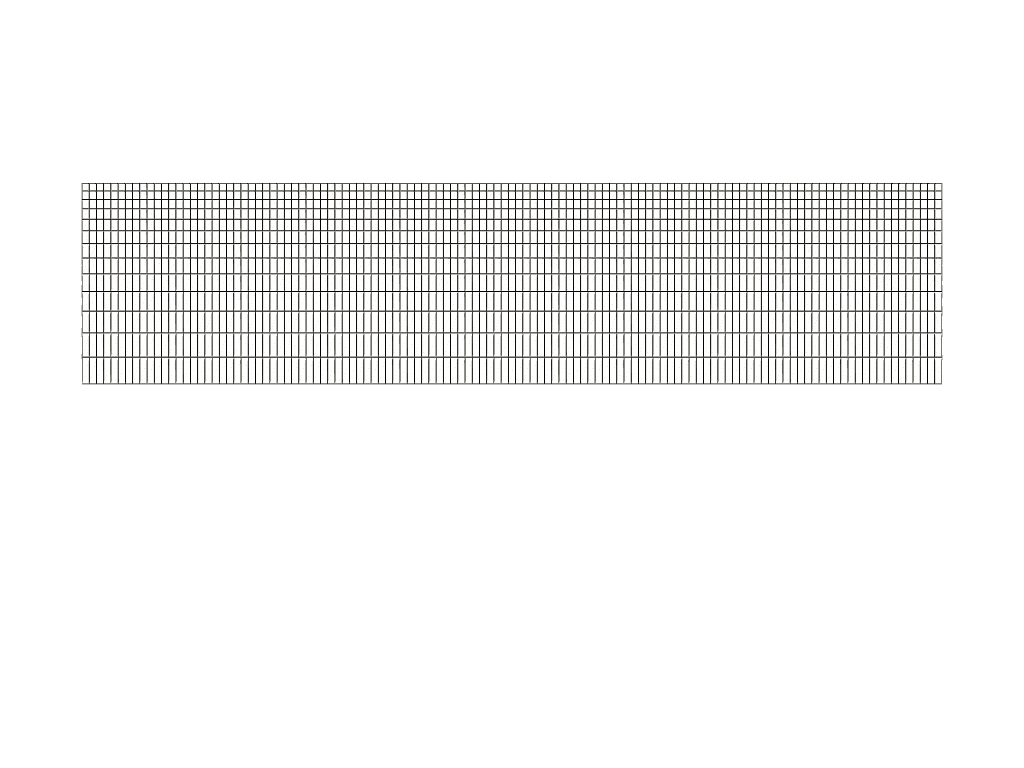

In [6]:
cpos = ((0.3, 0.0, 1.0),
        (0.3, 0.0, 0.0),
        (0.0, 0.0, 0.0))

mtm = np.array([[1., 0., 0., 0.],
                [0., 10., 0., 0.],
                [0., 0., 1., 0.],
                [0., 0., 0., 1.]])

grid = pv.read(case_view)
# grid.plot(cpos=cpos, show_edges=True, color="w", background="w",
#           window_size=(1000, 200), )

p = pv.Plotter(notebook=True)
p.set_background(color="w")
p.add_mesh(grid.copy(), show_edges=True, color="w")
p.camera.model_transform_matrix = mtm
p.show(cpos=cpos)

## Case fields template

In [7]:
boundaries = ["inlet", "outlet", "wall", "front", "back"]
boundaryField = fu.boundary_fields_template(boundaries)

## General initial state

In [8]:
T = 900.0 + 273.15
P = 5000.0

In [26]:
body_p = dedent(boundaryField.render(
    dimensions="[1 -1 -2 0 0 0 0]",
    uniform=P,
    inlet="""\
        type            zeroGradient;\
    """,
    outlet="""\
        type            totalPressure;
            p0              $internalField;\
    """,
    wall="""\
        type            zeroGradient;\
    """,
    front="""\
        type            wedge;\
    """,
    back="""\
        type            wedge;\
    """
))
# print(body_p)

In [30]:
body_U = dedent(boundaryField.render(
    dimensions="[0 1 -1 0 0 0 0]",
    uniform="(0 0 0)",
    inlet="""\
        // TODO compute actually velocity, less confusing than this.
            type                flowRateInletVelocity;
            // Make sure you made this proportional to 5 deg/360 deg
            massFlowRate        5.779772718769e-08;
            extrapolateProfile  yes;
            rho                 rho;
            rhoInlet            5.550024816471e-02;
            value               uniform (0 0 0);\
    """,
    outlet="""\
        type            pressureInletOutletVelocity;
            value           $internalField;\
    """,
    wall="""\
        type            noSlip;\
    """,
    front="""\
        type            wedge;\
    """,
    back="""\
        type            wedge;\
    """
))
# print(body_U)

In [28]:
body_T = dedent(boundaryField.render(
    dimensions="[0 0 0 1 0 0 0]",
    uniform="310",
    inlet="""\
        type            fixedValue;
        value           uniform 310;\
    """,
    outlet="""\
        type            inletOutlet;
        inletValue      uniform 310;
        value           uniform 310;\
    """,
    wall="""\
        type  codedFixedValue;
            value $internalField;
            name  pipe_body_BC;

            code
            #{
                double Tset = 0.98 * 1173.0;
                double aU = 0.13060308, nU = 6.545518790;
                double aD = 0.50220453, nD = 19.51147429;

                vector axisX = vector(1, 0, 0);
                scalarField x = (patch().Cf() & axisX);

                scalarField u = Foam::pow(x / aU, nU);
                scalarField d = Foam::pow(x / aD, nD);

                scalarField Tu = (Tset - 301.0) * (1 - Foam::exp(-u));
                scalarField Td = (Tset - 400.0) * (1 - Foam::exp(-d));

                scalarField Tval = 301 + Tu - Td;
                operator==(Tval);
            #};\
    """,
    front="""\
        type            wedge;\
    """,
    back="""\
        type            wedge;\
    """
))
# print(body_T)

## Species initial state

In [12]:
C = 0.36
X = {"N2":       0.64,
     "C2H2":     0.980 * C,
     "CH3COCH3": 0.018 * C,
     "CH4":      0.002 * C}

gas = ct.Solution(case_mech_ct, "gas")
gas.TPX = T, P, X

Y = gas.mass_fraction_dict()
Y["total"] = sum(Y.values())
pd.DataFrame.from_dict([Y])

,C2H2,CH3COCH3,CH4,N2,total
0,0.334007,0.013684,0.00042,0.651889,1.0


In [13]:
species_template = Template(
    boundaryField.render(
        dimensions="[0 0 0 0 0 0 0]",
        uniform="{{ inlet }}",
        inlet="""\
        type            fixedValue;
            value           uniform {{ inlet }};\
        """,
        outlet="""\
        type            inletOutlet;
            inletValue      uniform {{ inlet }};
            value           uniform {{ inlet }};\
        """,
        wall="""\
        type            zeroGradient;\
        """,
        front="""\
        type            wedge;\
        """,
        back="""\
        type            wedge;\
        """
    )
)
# print(species_template.render())

In [14]:
body_C2H2     = dedent(species_template.render(inlet=Y["C2H2"]))
body_CH3COCH3 = dedent(species_template.render(inlet=Y["CH3COCH3"]))
body_CH4      = dedent(species_template.render(inlet=Y["CH4"]))
body_N2       = dedent(species_template.render(inlet=Y["N2"]))
body_Ydefault = dedent(species_template.render(inlet=0.0))
# print(body_N2)

In [15]:
body_chemistryProperties = """\
chemistryType
{
    chemistrySolver  ode;
    chemistryThermo  psi;
    TDAC             off;
}

chemistry     on;

importantSpecies
{
    C2H2;
}

initialChemicalTimeStep 1.000000000000e-07;

odeCoeffs
{
    solver          seulex;
    absTol          1.0e-12;
    relTol          1.0e-03;
}

reduction
{
    // Off by default
    active  off;

    // Tolerance depends on the reduction method, see details for each method
    tolerance   0.0001;

    // Available methods: DRG, DAC, DRGEP, PFA, EFA
    method DRG;

    // Search initiating set (SIS) of species, needed for most methods
    initialSet
    {
        C2H2;
    }

    // For DAC, option to automatically change the SIS switch from HO2 to H2O
    // and CO to CO2, + disable fuel
    automaticSIS    off;

    // When automaticSIS, the method needs to know the fuel
    //fuelSpecies
    //{
    //    CH4 1.0;
    //}
}

tabulation
{
    active             off;

    printProportion    off;

    printNumRetrieve   off;

    // Tolerance used for retrieve and grow
    tolerance    1.0e-04;

    // ISAT is the only method currently available
    method    ISAT;

    // Scale factors used in the definition of the ellipsoid of accuracy
    scaleFactor
    {
        otherSpecies 1.0;
        Temperature  5E4;
        Pressure     1E15;
        deltaT       1;
    }

    // Maximum number of leafs stored in the binary tree
    maxNLeafs  2000;

    // Maximum life time of the leafs (in time steps) used in unsteady
    // simulations to force renewal of the stored chemPoints and keep the tree
    // small
    chPMaxLifeTime 1;

    // Maximum number of growth allowed on a chemPoint to avoid distorted
    // chemPoints
    maxGrowth  1;

    // Number of time steps between analysis of the tree to remove old
    // chemPoints or try to balance it
    checkEntireTreeInterval  1;

    // Parameters used to decide whether to balance or not if the tree's depth
    // is larger than maxDepthFactor*log2(nLeafs) then balance the tree
    maxDepthFactor   2;

    // Try to balance the tree only if the size of the tree is greater
    minBalanceThreshold 30;

    // Activate the use of a MRU (most recently used) list
    MRURetrieve false;

    // Maximum size of the MRU list
    maxMRUSize 0;

    // Allow to grow points
    growPoints  true;

    // When mechanism reduction is used, new dimensions might be added
    // maxNumNewDim set the maximum number of new dimensions added during a
    // growth
    maxNumNewDim 1;
}
"""

In [16]:
body_combustionProperties = """\
combustionModel laminar<psiChemistryCombustion>;

active  true;
"""

body_g = """\
dimensions      [0 1 -2 0 0 0 0];

value           (0.000000000000e+00 -9.810000000000e+00 0.000000000000e+00);
"""

body_thermophysicalProperties = """\
thermoType
{
    type            hePsiThermo;
    mixture         reactingMixture;
    transport       sutherland;
    thermo          janaf;
    energy          sensibleEnthalpy;
    equationOfState perfectGas;
    specie          specie;
}

inertSpecie N2;

chemistryReader         foamChemistryReader;
foamChemistryFile       "<constant>/reactions";
foamChemistryThermoFile "<constant>/thermo";
"""

body_turbulenceProperties = """\
simulationType   laminar;
"""

## System

In [17]:
body_controlDict = """\
application       reactingFoam;

startFrom         latestTime;

startTime         0;

stopAt            endTime;

endTime           5.0;

deltaT            1.0e-05;

writeControl      runTime;

writeInterval     0.05;

purgeWrite        0;

writeFormat       ascii;

writePrecision    6;

writeCompression  off;

timeFormat        scientific;

timePrecision     6;

runTimeModifiable true;

maxCo             0.25;
"""

In [18]:
body_fvSchemes = """\
ddtSchemes
{
    default          localEuler;
}

gradSchemes
{
    default          Gauss linear;
}

divSchemes
{
    default          none;
    div(phid,p)      Gauss limitedLinear 1;
    div(phi,U)       Gauss limitedLinearV 1;
    div(phi,K)       Gauss limitedLinear 1;
    div(phi,Yi_h)    Gauss limitedLinear01 1;
    div(((rho*nuEff)*dev2(T(grad(U))))) Gauss linear;
}

laplacianSchemes
{
    default          Gauss linear orthogonal;
}

interpolationSchemes
{
    default          linear;
}

snGradSchemes
{
    default          orthogonal;
}
"""

In [19]:
body_fvSolution = """\
solvers
{
    "rho.*"
    {
        solver          diagonal;
    }

    p
    {
        solver          PCG;
        preconditioner  DIC;
        tolerance       1.0e-06;
        relTol          0.01;
    }

    pFinal
    {
        $p;
        relTol          0;
    }

    U
    {
        solver          PBiCGStab;
        preconditioner  DILU;
        tolerance       1.0e-06;
        relTol          0.1;
    }

    UFinal
    {
        solver          PBiCGStab;
        preconditioner  DILU;
        tolerance       1.0e-06;
        relTol          0.1;
    }

    h
    {
        solver          PBiCGStab;
        preconditioner  DILU;
        tolerance       1.0e-07;
        relTol          0.1;
    }

    hFinal
    {
        solver          PBiCGStab;
        preconditioner  DILU;
        tolerance       1.0e-09;
        relTol          0.1;
    }
    
    Yi
    {
        solver          PBiCGStab;
        preconditioner  DILU;
        tolerance       1.0e-12;
        relTol          0.01;
    }
}

PIMPLE
{
    momentumPredictor        no;
    nOuterCorrectors         1;
    nCorrectors              2;
    nNonOrthogonalCorrectors 0;

    maxDeltaT           1e-4;
    maxCo               0.25;
    alphaTemp           0.05;
    alphaY              0.05;
    Yref
    {
        N2                  0.5;
        H2                  0.1;
        C2H2                0.3;
    }
    rDeltaTSmoothingCoeff   0.025;
    rDeltaTDampingCoeff     1;
}

relaxationFactors
{
    fields
    {
        p               0.3;
    }
    equations
    {
        U               0.7;
        ".*"            0.4;
    }
}
"""

In [20]:
body_decomposeParDict = """\
numberOfSubdomains  4;

method              hierarchical;

coeffs
{
    n               (4 1 1);
}
"""

In [21]:
source = "/usr/lib/openfoam/openfoam2106/etc/bashrc"

fu.make_file(case, "0.000000e-00", "p",                        body_p)
fu.make_file(case, "0.000000e-00", "U",                        body_U)
fu.make_file(case, "0.000000e-00", "T",                        body_T)
fu.make_file(case, "0.000000e-00", "C2H2",                     body_C2H2,     class_type="scalar")
fu.make_file(case, "0.000000e-00", "CH3COCH3",                 body_CH3COCH3, class_type="scalar")
fu.make_file(case, "0.000000e-00", "CH4",                      body_CH4,      class_type="scalar")
fu.make_file(case, "0.000000e-00", "N2",                       body_N2,       class_type="scalar")
fu.make_file(case, "0.000000e-00", "Ydefault",                 body_Ydefault, class_type="scalar")
fu.make_file(case, "constant",     "chemistryProperties",      body_chemistryProperties)
fu.make_file(case, "constant",     "combustionProperties",     body_combustionProperties)
fu.make_file(case, "constant",     "g",                        body_g)
fu.make_file(case, "constant",     "thermophysicalProperties", body_thermophysicalProperties)
fu.make_file(case, "constant",     "turbulenceProperties",     body_turbulenceProperties)
fu.make_file(case, "system",       "controlDict",              body_controlDict)
fu.make_file(case, "system",       "decomposeParDict",         body_decomposeParDict)
fu.make_file(case, "system",       "fvSchemes",                body_fvSchemes)
fu.make_file(case, "system",       "fvSolution",               body_fvSolution)
    
shutil.copy(case_mesh,    f"{case}/mesh.msh")
shutil.copy(case_mech_of, f"{case}/constant/reactions")
shutil.copy(case_ther_of, f"{case}/constant/thermo")

'cases/foam-day-16-tutorial-02-pyrolysis-alt/constant/thermo'

In [22]:
# fu.run_cmd(case, "log.gmshToFoam",   f". {source} && gmshToFoam mesh.msh")

# fu.run_cmd(case, "log.tmp", f". {source} && pyFoamChangeBoundaryType.py . front wedge")
# fu.run_cmd(case, "log.tmp", f". {source} && pyFoamChangeBoundaryType.py . back  wedge")

# fu.run_cmd(case, "log.reactingFoam", f". {source} && reactingFoam")
# foamLog log.reactingFoam

## Post-processing

In [23]:
# cpos = ((0.3, 0.006, 1.0),
#         (0.3, 0.006, 0.0),
#         (0.0, 0.0, 0.0))

# opts = dict(
#     cmap="jet",
#     pbr=False,
#     scalar_bar_args=dict(
#         height=0.1,
#         width=0.8, 
#         vertical=False, 
#         position_x=0.10,
#         position_y=0.15,
#         color="w",
#         n_colors=10,
#         n_labels=11,
#         fmt="%.3f"
#     )
# )

# mtm = np.array([[1., 0., 0., 0.],
#                 [0., 20., 0., 0.],
#                 [0., 0., 1., 0.],
#                 [0., 0., 0., 1.]])

# mesh = pv.read(f"{case}/VTK/foam-day-16-tutorial-02-pyrolysis_50000/internal.vtu")
# midplane = mesh.slice(normal=[0, 0, 1])
# ucontour = midplane.contour(10, scalars="U")
# ycontour = midplane.contour(10, scalars="C2H2")

# p = pv.Plotter(shape="1/1", notebook=True)
# p.set_background(color="k")

# p.subplot(0)
# p.add_mesh(midplane, **opts, scalars="U")
# p.add_mesh(ucontour, color="k", line_width=1)

# p.subplot(1)
# p.add_mesh(midplane, **opts, scalars="C2H2")

# p.link_views()
# p.add_axes()
# p.camera.model_transform_matrix = mtm
# p.show(cpos=cpos)

In [24]:
# mesh.plot(scalars="T", cpos=cpos)